# Map fires in Orroral Valley using Entropy/Alpha
- Fire Mapping in SAR Reference https://www.mdpi.com/2072-4292/9/8/764/htm
- Locate Datasets over Orroral Valley using [Copernicus Hub Australia](https://copernicus.nci.org.au/sara.client/#/explore).
- Download them form [NCI Thredds](http://dapds00.nci.org.au/thredds/catalog/fj7/Copernicus/Sentinel-1/C-SAR/SLC/catalog.xml).
- Load them via GDAL [Complex Tiff](https://gdal.org/drivers/raster/gtiff.html) with Cfloat64 datatype, allocate enough RAM for this.
- Analyse them in Slant Range with [PyRAT](https://github.com/birgander2/PyRAT)
- Convert to Ground range/Orthorectified versions using SNAP/Gamma

In [1]:
import requests
import zipfile
import logging
import os
import re
import urllib.request
import glob
import xarray
import zipfile
from pylab import plot, show, imshow, figure, scatter
import matplotlib.pyplot as plt
import pyodata
from auscophub import saraclient
from shapely.geometry import Point
import osgeo.gdal as gdal

## Locate Images via Copernicus Hub SARA API
- Use location of [Orroral Valley](https://www.google.com/maps/place/Orroral+Valley/@-35.6168882,148.6665058,10z/data=!4m13!1m7!3m6!1s0x6b17d73435882e61:0x2440e61df2404dce!2sOrroral+Valley!3b1!8m2!3d-35.61689!4d148.9466573!3m4!1s0x6b17d73435882e61:0x2440e61df2404dce!8m2!3d-35.61689!4d148.9466573)
- Use Copernicus Hub [SARA search API](https://github.com/CopernicusAustralasia/auscophub/blob/master/bin/auscophub_searchSara.py)

In [2]:
orroral_polygon = Point(148.96,-35.58).buffer(0.01)

In [3]:
queryParams = [
               'collection=S1',
               'instrument=C-SAR',
               'productType=SLC',
               'startDate=2019-12-01',
               'completionDate=2020-02-04',
               'page=1',
               'orbitNumber=147',
              'geometry='+orroral_polygon.to_wkt()]

In [4]:
urlOpener = saraclient.makeUrlOpener()
results = saraclient.searchSara(urlOpener, 1, queryParams)

In [5]:
from math import ceil, floor

def str_lat(lat):
    if lat < 0:
        return f'{abs(lat)}S'
    return f'{lat}N'
    
def str_lon(lon): 
    if lon < 0:
        return f'{abs(lon)}W'
    return f'{lon}E'
    
def infer_nci_folder(scene_props):
    ql_url = scene_props['quicklook']
    path_part = ql_url.rsplit('/',2)[1]
    x,y = scene_props['centroid']['coordinates']
    # Round x,y to 5
    round_x = 5 * floor(x/5)
    round_y = 5 * ceil(y/5)
    plus_round_x = round_x + 5
    plus_round_y = round_y - 5
    composed_path_part = f'{str_lat(round_y)}{str_lon(round_x)}-{str_lat(plus_round_y)}{str_lon(plus_round_x)}'
    if path_part != composed_path_part:
        logging.error(f'Expected {composed_path_part}, got {path_part}')
        raise Exception
    return path_part

In [6]:
thumbnails = [x['properties']['thumbnail'] for x in results]

In [7]:
scene_ids = [x['properties']['productIdentifier'] for x in results]

In [8]:
base_url = 'http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC'

In [9]:
loc_folder = infer_nci_folder(results[0]['properties'])

In [10]:
def parse_ym(granule_name):
    ym = granule_name.replace('S1A_IW_SLC__1SDV_','')[:6]
    return ym[:4],ym[-2:]

In [11]:
def compose_url(scene_id):
    year,month = parse_ym(scene_id)
    full_url = f'{base_url}/{year}/{year}-{month}/{loc_folder}/{scene_id}.zip'
    return full_url

In [12]:
for scene in scene_ids:
    url = compose_url(scene)
    print(url)
    filename = f'{scene}.zip'
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url,filename)
        except HTTPError as hte:
            print(f"Failed to Download:{url}")

http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200117T191613_20200117T191640_030844_038A00_75C1.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200105T191613_20200105T191640_030669_0383E0_44C8.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S145E-40S150E/S1A_IW_SLC__1SDV_20191224T191614_20191224T191641_030494_037DD5_C06C.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S145E-40S150E/S1A_IW_SLC__1SDV_20191212T191614_20191212T191641_030319_0377C8_F3C3.zip


In [13]:
for scene in scene_ids:
    filename = f'{scene}.zip'
    out_dir = f'{scene}.SAFE'
    print(out_dir)
    if not os.path.isdir(f'{scene}.SAFE'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            try:
                zip_ref.extractall('.')
            except:
                print(f"Corrupted :{filename}")
                os.unlink(filename)

S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE
S1A_IW_SLC__1SDV_20200117T191613_20200117T191640_030844_038A00_75C1.SAFE
S1A_IW_SLC__1SDV_20200105T191613_20200105T191640_030669_0383E0_44C8.SAFE
S1A_IW_SLC__1SDV_20191224T191614_20191224T191641_030494_037DD5_C06C.SAFE
S1A_IW_SLC__1SDV_20191212T191614_20191212T191641_030319_0377C8_F3C3.SAFE


## GDAL GCP Mechanism for Quick georeferencing
- SLC data carries a grid of GCP's for indicative georeferencing
- [Helmert transforms](https://proj.org/operations/transformations/helmert.html) can be performed for low distortion warping of SLC domain products approximately to geographic co-ordinates

In [14]:
s1_ds = gdal.Open('S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE')

In [15]:
sds_list = s1_ds.GetSubDatasets()
IW1_ds = gdal.Open(sds_list[2][0])
IW2_ds = gdal.Open(sds_list[5][0])
IW3_ds = gdal.Open(sds_list[8][0])

In [16]:
lon_1 = [gcp.GCPX for gcp in IW1_ds.GetGCPs()]
lat_1 = [gcp.GCPY for gcp in IW1_ds.GetGCPs()]
lon_2 = [gcp.GCPX for gcp in IW2_ds.GetGCPs()]
lat_2 = [gcp.GCPY for gcp in IW2_ds.GetGCPs()]
lon_3 = [gcp.GCPX for gcp in IW3_ds.GetGCPs()]
lat_3 = [gcp.GCPY for gcp in IW3_ds.GetGCPs()]

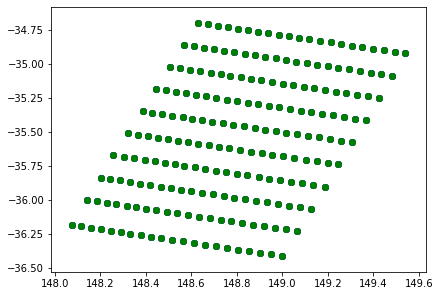

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
axs.scatter(lon_1,lat_1,color='k')
axs.scatter(lon_2,lat_2,color='b')
axs.scatter(lon_2,lat_2,color='g')

## Some exploratory plotting of Orroral SLC Data
- Plot image snippets to check alignment in pixel co-ordinated
- Plot Histograms to show any overall backscatter changes

In [18]:
import os
import numpy as np

import osgeo.gdal as gdal

datasets = [f'{scene}.SAFE/measurement' for scene in scene_ids]
data_collection = {}
for data in datasets:
    tiff_files = glob.glob(os.path.join(data,'*.tiff'))
    for tiff in tiff_files:
        if 's1a-iw2' in tiff:
            ds = gdal.Open(tiff)
            xsize = ds.RasterXSize
            ysize = ds.RasterYSize
            data = ds.ReadAsArray(int(xsize/4),int(ysize/4),1000,1000)
            data_collection[tiff] = data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


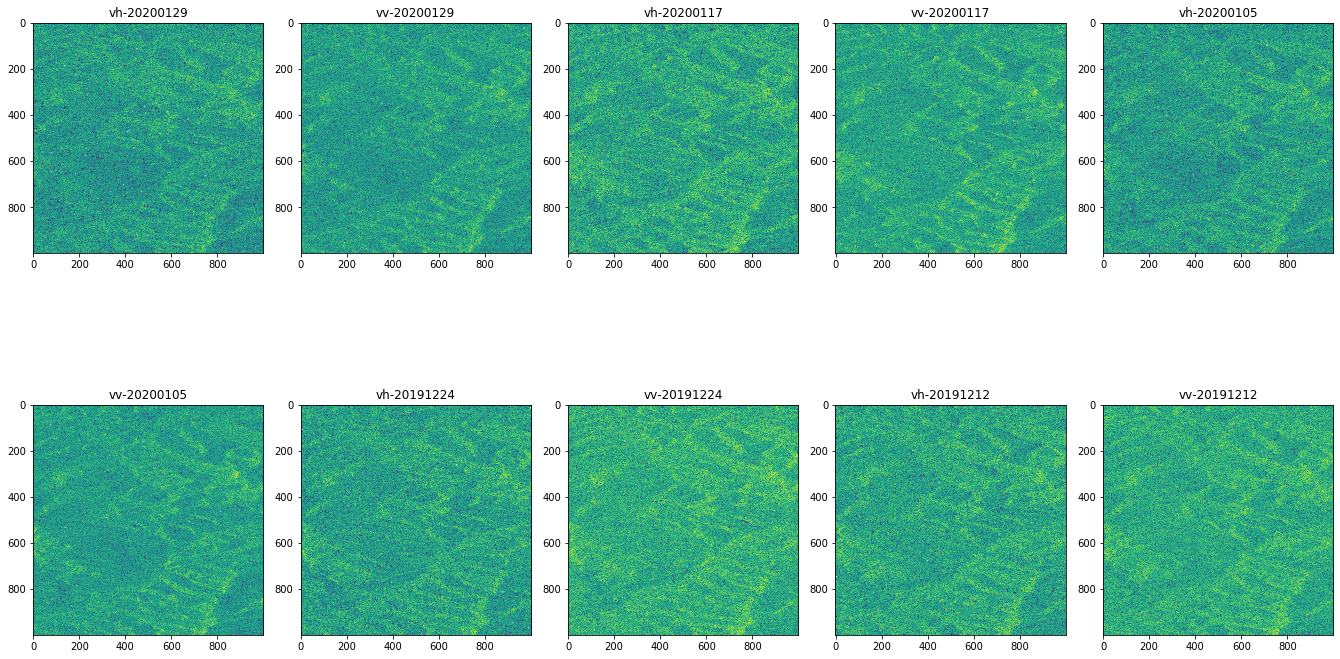

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=int(len(data_collection)/2), constrained_layout=True)
fig.set_size_inches(18.5, 10.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    decibel = np.log(np.absolute(data_collection[keys[i]])**2)*10
    ax.imshow(decibel)
    basename = os.path.basename(key)
    ax.set_title(basename[12:23])
    i += 1

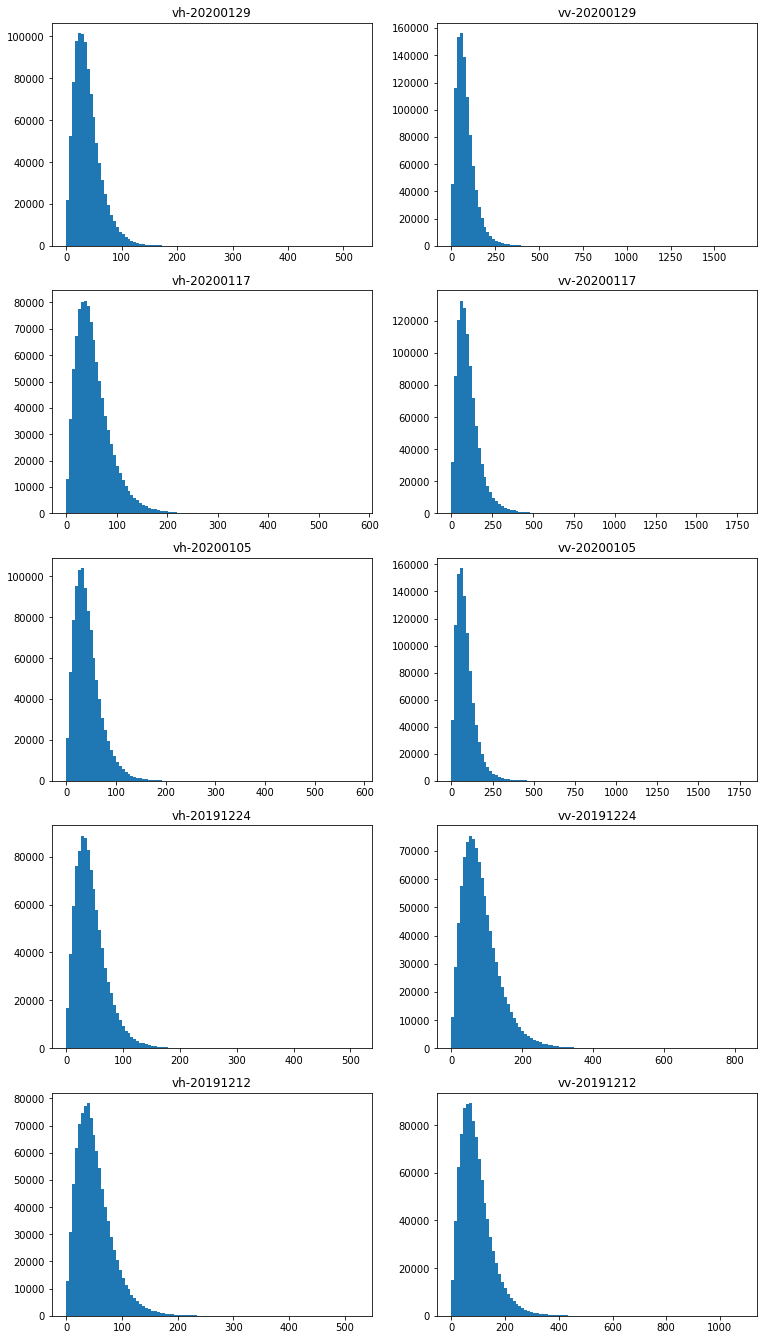

In [20]:
fig, axs = plt.subplots(nrows=int(len(data_collection)/2), ncols=2, constrained_layout=True)
fig.set_size_inches(10.5, 18.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    basename = os.path.basename(key)
    pol_date = basename[12:23]
    data = data_collection[keys[i]]
    data_no_nan = np.nan_to_num(np.absolute(data))
    counts, bins = np.histogram(data_no_nan.flatten(),bins=100)
    ax.hist(bins[:-1], bins=100, weights=counts)
    ax.set_title(pol_date)
    i += 1

## Install PyRAT before next steps
- Pip install PyQT5
- Pip install Cython for acceleration
- Pip install PyRAT or clone from github to use from source

In [21]:
from pyrat import *
pyrat_init()

  DEBUG: Loaded backend Qt5Agg version unknown.
  
  Welcome to PyRAT (v0.62-oss)
  OS detected : linux
  Temporary directory: /mnt/d/tmp_rat
  Pool with 8 workers initialised

  help() will show a list of available commands!
  
  Welcome to PyRAT (v0.62-oss)
  OS detected : linux
  Temporary directory: /mnt/d/tmp_rat
  Pool with 8 workers initialised

  help() will show a list of available commands!


In [22]:
s1 = load.sentinel1(dir='S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE',swath=2)

  SENTINEL-1 IMPORT  {'dir': 'S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE', 'swath': 2}
  Activating ['/L1', '/L2']


In [23]:
info()


  /L1 *                          D complex64  (13572, 26843)
  /L2 *                          D complex64  (13572, 26843)


In [24]:
activate(['/L1','/L2'])

  Activating ['/L1', '/L2']


In [25]:
getmeta()

[{'ACQUISITION_START_TIME': '2020-01-29T19:16:13.003352',
  'ACQUISITION_STOP_TIME': '2020-01-29T19:16:39.966084',
  'BEAM_MODE': 'IW',
  'BEAM_SWATH': 'IW1',
  'FACILITY_IDENTIFIER': 'Copernicus S1 Core Ground Segment - DPA',
  'LINE_SPACING': '1.407137e+01',
  'MISSION_ID': 'S1A',
  'MODE': 'IW',
  'ORBIT_DIRECTION': 'DESCENDING',
  'ORBIT_NUMBER': '31019',
  'PIXEL_SPACING': '2.329562e+00',
  'PRODUCT_TYPE': 'SLC',
  'SATELLITE_IDENTIFIER': 'SENTINEL-1',
  'SENSOR_IDENTIFIER': 'SAR',
  'SWATH': 'IW2',
  'sensor': 'Sentinel-1'},
 {'ACQUISITION_START_TIME': '2020-01-29T19:16:13.003352',
  'ACQUISITION_STOP_TIME': '2020-01-29T19:16:39.966084',
  'BEAM_MODE': 'IW',
  'BEAM_SWATH': 'IW1',
  'FACILITY_IDENTIFIER': 'Copernicus S1 Core Ground Segment - DPA',
  'LINE_SPACING': '1.407137e+01',
  'MISSION_ID': 'S1A',
  'MODE': 'IW',
  'ORBIT_DIRECTION': 'DESCENDING',
  'ORBIT_NUMBER': '31019',
  'PIXEL_SPACING': '2.329562e+00',
  'PRODUCT_TYPE': 'SLC',
  'SATELLITE_IDENTIFIER': 'SENTINEL-1',
 